# Social Network Analysis group project 📊

***

## Group members 👥
- Michele Turco
- Simone Filosofi
- Edoardo Cocciò
- Lorenzo Laterza

In [70]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json

In [71]:
nodes_df = pd.read_csv('data/nodes.csv', index_col=0,sep = ',')
edges_df = pd.read_csv('data/edges.csv')

nodes_df[' viz'] = nodes_df[' viz'].apply(lambda row: row.replace("'", '"')).apply(json.loads)
nodes_df['size'] = nodes_df[' viz'].apply(lambda row: row['size'] * 20)

nodes_df[' _pos'] = nodes_df[' _pos'].apply(lambda row: (float(row[7:18]), float(row[20:-2])))

In [72]:
links = edges_df['coordinates'] = edges_df.apply(lambda row: (row['# source'], row[' target'], row[' weight']), axis=1)

labels = enumerate(nodes_df[' label'])
labels = dict(labels)

pos = nodes_df[' _pos']

colors = []
for n in range(0,94):
    color = nodes_df[' viz'][n]['color']
    accepted_format = (color['r']/255, color['g']/255, color['b']/255, color['a'])
    colors.append(accepted_format)

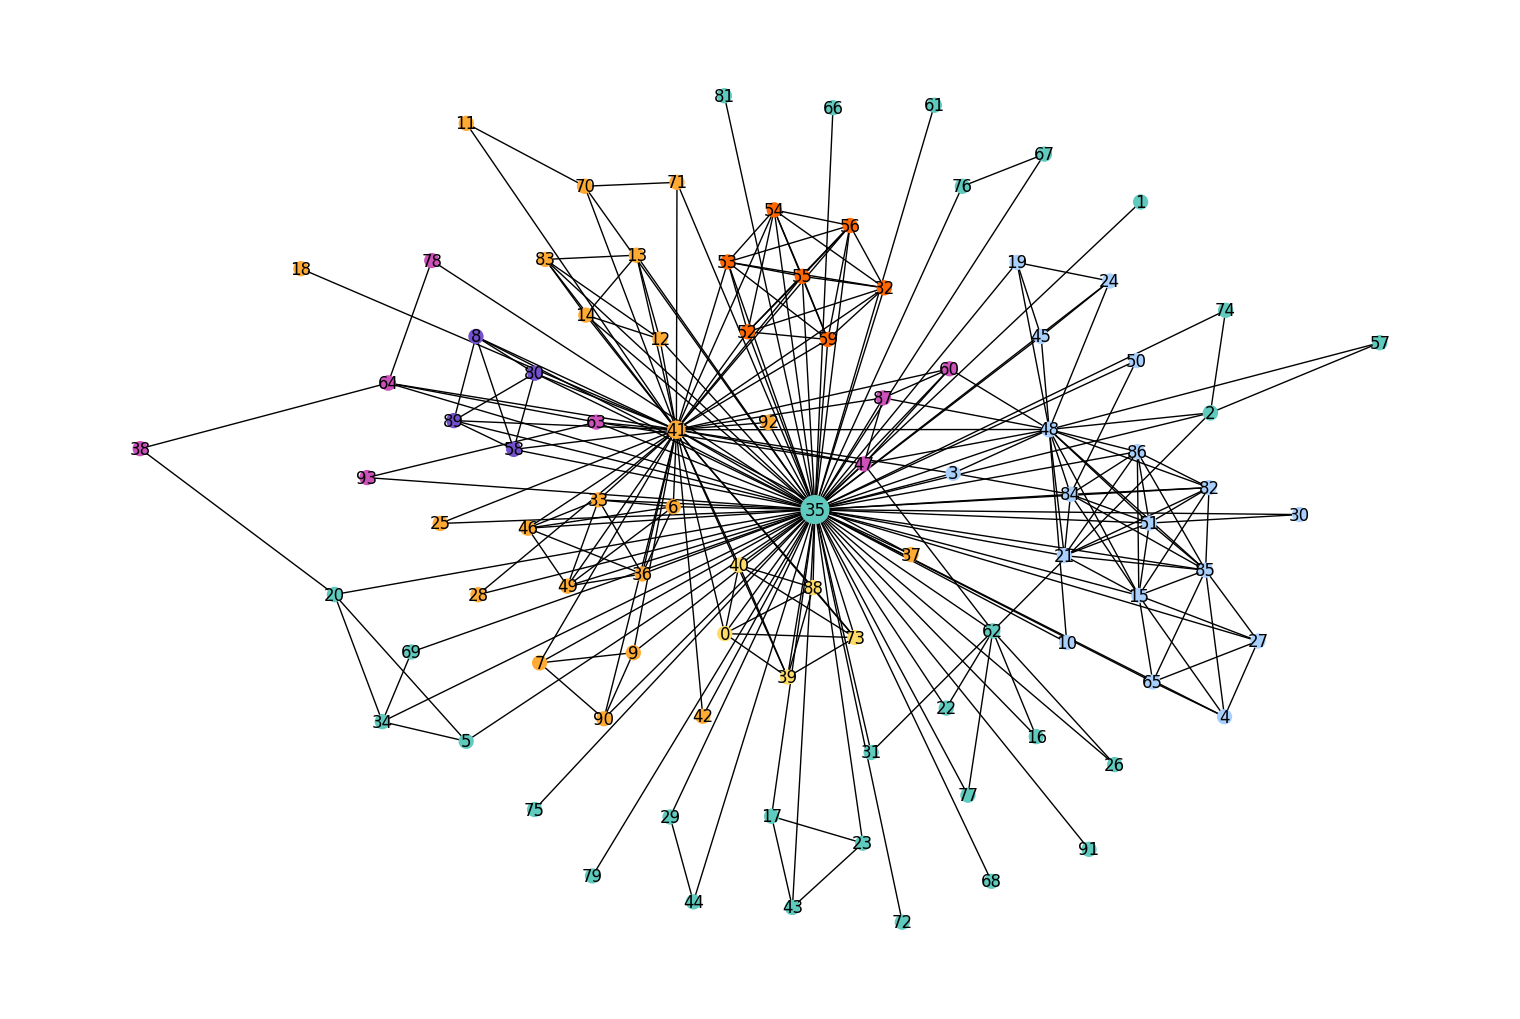

In [73]:
plt.figure(figsize=(15, 10))
G = nx.Graph()

for n in range(0, len(nodes_df)):
    G.add_node(n)

G.add_weighted_edges_from(links)
nx.set_node_attributes(G, labels, name = 'label')


nx.draw(G, node_size = nodes_df['size'], pos = pos, with_labels = True, node_color = colors)

## Number of nodes

In [74]:
G.number_of_nodes()

94

## Number of edges

In [75]:
G.number_of_edges()

271

## Density

In [76]:
nx.density(G)

0.06199954243880119

## Checking what's the largest component of the graph
Since all nodes are connected we are considering the entire graph for the following computations

In [77]:
cc = [i for i in nx.connected_components(G)]
len(cc)

1

## Diameter

In [78]:
nx.diameter(G) # the maximum distance between two nodes iinside the graph

4

## Average Shortest Path Length

In [79]:
nx.average_shortest_path_length(G)

1.9949668268130862

## Average Clustering

In [80]:
nx.average_clustering(G)

0.8002425574908809

## Transitivity implementation using basic networkx functions

In [81]:
# T = 3 * (Number of triangles) / ( N(N-1) / 2 )

def count_triangles(G):
    "Count the number of triangles in the graph without using nx.triangles "
    triangles = 0
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                u, v = neighbors[i], neighbors[j]
                if G.has_edge(u, v):
                    triangles += 1
    return triangles   # Each triangle is counted 3 times (once for each node)

def transitivity(G):
# Actual number of triangles is 'triangles'/3, but the denominator semplifies with the '3' in the main formula

    triangles = count_triangles(G) # number of triangles inside the graph
    sum_of_degrees = 0

    for node in G.nodes():
        fraction = (G.degree(node) * (G.degree(node) - 1))/2 # number of wedges
        sum_of_degrees += fraction

    return triangles / sum_of_degrees

print(f"Transitivity results:\n---------------------------------------  \nOur implementation: {transitivity(G)} \nNetworkx: {nx.transitivity(G)}")


Transitivity results:
---------------------------------------  
Our implementation: 0.1918081918081918 
Networkx: 0.1918081918081918


## Closeness centrality 

To compute the **closeness centrality of node** _i_:
$$g_{i} = \frac{1}{\sum\limits_{i \ne j}\ell(i,j)}$$
where $\ell(i,j)$ is the distance (shortest path) between the two nodes.

To get a more relevant result we compute the **normalized closeness centrality**:
$$C_{i}^{clo} = g_{i}\cdot (N-1) = \frac{N - 1}{\sum\limits_{i \ne j}\ell(i,j)}$$

In [101]:
def shortest_path(graph, start, target):
    path_list = [[start]]
    path_index = 0
    # To keep track of previously visited nodes
    previous_nodes = {start}
    if start == target:
        return path_list[0]
        
    while path_index < len(path_list):
        current_path = path_list[path_index]
        last_node = current_path[-1]
        next_nodes = graph[last_node]
        # Search target node
        if target in next_nodes:
            current_path.append(target)
            return current_path[1:]
        # Add new paths
        for next_node in next_nodes:
            if not next_node in previous_nodes:
                new_path = current_path[:]
                new_path.append(next_node)
                path_list.append(new_path)
                # To avoid backtracking
                previous_nodes.add(next_node)
        # Continue to next path in list
        path_index += 1
    # In case no path is found
    return []

[2, 57]

In [121]:
def shortest_paths(graph, start):

    spl = dict()

    for node in graph.nodes():
        if (start, node) in graph.edges():
            spl[node] = 1
        else:
            spl[node] = len(shortest_path(G,start,node))

    return spl

In [126]:
def normalized_closeness_centrality(graph, node):
    return (len(graph.nodes()) - 1) / sum(shortest_paths(graph, node).values())

print(f"Centrality of node 35 is: {normalized_closeness_centrality(G, 35)}")
print(f"Centrality of node 41 is: {normalized_closeness_centrality(G,41)}")

Centrality of node 35 is: 0.9489795918367347
Centrality of node 41 is: 0.6549295774647887
